# GNILC Dust templates for PySM 3
> Dust templates based on Planck GNILC maps in logarithmic polarization fraction formalism (logpoltens) with injection of simulated small scale fluctuations

This notebook implements and validates the model at Nside 2048, see the related notebooks:

* [Simplified version of this notebook ran for an output Lmax of 16384, saving all the artifacts needed to create templates at higher resolution](small_scale_dust_pysm3_generate_artifacts.ipynb)
* [Notebooks that given the artifacts generates the templates at nside 2048, 4096 and 8192](small_scale_dust_pysm3_generate_templates.ipynb)

Below a summary of the updates implemented on new dust models : 
- input templates from GNILC variable resolution and unires GNILC maps
- two pivot scales `ell1=110`,`ell2=2000` for small scale injection (see my previous posts ) 
- spectral indices for EE, BB coming from literature , [Planck 2018 XI](https://arxiv.org/pdf/1801.04945.pdf) and for TT from [Miville-Deschenes 2016](https://www.aanda.org/articles/aa/pdf/2016/09/aa28503-16.pdf)
- we inject small scales with non-zero TE from [Planck 2018 XI](https://arxiv.org/pdf/1801.04945.pdf)
- Inside the GAL097 mask (i.e. along the Gal. midplane) we don't inject small scales, we simply keep the ones observed at high SNR by Planck.
- Modulation of qu maps with a single map, p:
 i. to avoid modulation w/ negative values,
 ii. to preserve non-zero TE 
- we propose to modulate small scales as it has been done in `pysm2`(https://arxiv.org/pdf/1608.02841.pdf) ,  with a couple of differences: 
 i. small scales are expected to be injected with   non-gaussian content (thanks to the  logpoltens formalism); 
ii. split the sky with  high reso pixels (nside=8) ; 
iii. use amplitude of E-mode spectra to derive the modulation template

In [1]:
from pathlib import Path
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from astropy.io import fits

%matplotlib inline

In [2]:
import os

# for jupyter.nersc.gov otherwise the notebook only uses 2 cores

os.environ["OMP_NUM_THREADS"] = "64"

In [3]:
hp.disable_warnings()

In [4]:
plt.style.use("seaborn-talk")

In [5]:
import pysm3 as pysm
import pysm3.units as u

In [6]:
nside = 2048
lmax = 2048

In [7]:
comp = "IQU"

In [8]:
components = list(enumerate(comp))
components

[(0, 'I'), (1, 'Q'), (2, 'U')]

In [9]:
spectra_components = ["TT", "EE", "BB", "TE"]

change this to True   if you want to  run namaster on notebook 


In [10]:
namaster_on_nb = True

In [11]:
datadir = Path("data")

# Setting the inputs 
## Dust maps 
- We use the  2015 GNILC intensity map from the 2nd planck release, as it encodes less contamination from CIB with 21.8' resolution https://portal.nersc.gov/project/cmb/pysm-data/dust_gnilc/inputs/COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits

- for Q and U we adopt maps from the 3rd Planck release as they were optimized for polarization studies with 80' reso.  



In [12]:
gnilc_template = "varres"
dust_varresI = datadir / "COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits"
dust_varresP = (
    datadir / f"COM_CompMap_IQU-thermaldust-gnilc-{gnilc_template}_2048_R3.00.fits"
)

In [13]:
if not dust_varresI.exists():
    !wget -O $dust_varresI https://portal.nersc.gov/project/cmb/pysm-data/dust_gnilc/inputs/COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits

--2023-02-10 08:12:26--  https://portal.nersc.gov/project/cmb/pysm-data/dust_gnilc/inputs/COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.107, 128.55.206.110, 128.55.206.109, ...
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 402664320 (384M)
Saving to: ‘data/COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits’

data/COM_CompMap_Du 100%[===================>] 384.01M  66.5MB/s    in 6.1s    

2023-02-10 08:12:32 (63.1 MB/s) - ‘data/COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits’ saved [402664320/402664320]



In [14]:
if not dust_varresP.exists():
    !wget -O $dust_varresP http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits

--2023-02-10 08:12:32--  http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits
Resolving pla.esac.esa.int (pla.esac.esa.int)... 193.147.153.153
Connecting to pla.esac.esa.int (pla.esac.esa.int)|193.147.153.153|:80... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [image/fits]
Saving to: ‘data/COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits’

data/COM_CompMap_IQ     [             <=>    ]   1.88G  17.3MB/s    in 1m 55s  

2023-02-10 08:14:28 (16.6 MB/s) - ‘data/COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits’ saved [2013275520]



Transform maps to double precision for computations

In [15]:
m_planck_varres, h = hp.read_map(
    dust_varresP, [c + "_STOKES" for c in comp], dtype=np.float64, h=True
)
I_planck_varres, h = hp.read_map(dust_varresI, dtype=np.float64, h=True)

Maps from the two releases are in different units `MJy/sr` the former, and `K_CMB` the latter, we therefore need to perform some conversion to `uK_RJ`. 

In [16]:
m_planck_varres <<= u.K_CMB
I_planck_varres <<= u.MJy / u.sr
m_planck_varres = m_planck_varres.to(
    "uK_RJ", equivalencies=u.cmb_equivalencies(353 * u.GHz)
)
I_planck_varres = I_planck_varres.to(
    "uK_RJ", equivalencies=u.cmb_equivalencies(353 * u.GHz)
)

then we are ready to combine both maps into one single TQU map. 

In [17]:
m_planck_varres[0] = I_planck_varres
del I_planck_varres

### GAL080 Planck  mask 

we perform the monopole removal in a region outside  the Galactic plane.  


In [18]:
planck_mask_filename = datadir / "HFI_Mask_GalPlane-apo2_2048_R2.00.fits"

if not planck_mask_filename.exists():
    !wget -O $planck_mask_filename "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=HFI_Mask_GalPlane-apo2_2048_R2.00.fits"

--2023-02-10 08:14:56--  http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=HFI_Mask_GalPlane-apo2_2048_R2.00.fits
Resolving pla.esac.esa.int (pla.esac.esa.int)... 193.147.153.153
Connecting to pla.esac.esa.int (pla.esac.esa.int)|193.147.153.153|:80... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [image/fits]
Saving to: ‘data/HFI_Mask_GalPlane-apo2_2048_R2.00.fits’

data/HFI_Mask_GalPl     [               <=>  ]   1.50G  16.7MB/s    in 96s     

2023-02-10 08:16:33 (15.9 MB/s) - ‘data/HFI_Mask_GalPlane-apo2_2048_R2.00.fits’ saved [1610622720]



masking 0.7912631829579672 of the sky


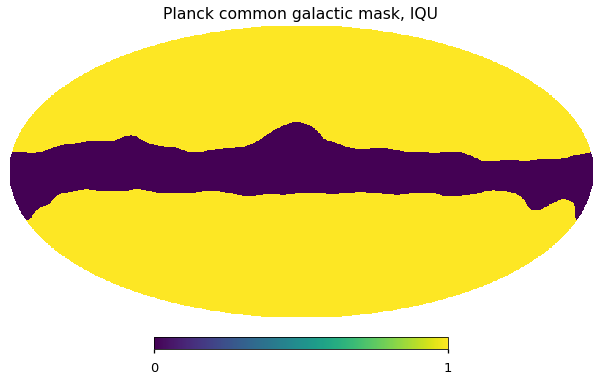

In [19]:
planck_mask = hp.read_map(planck_mask_filename, ["GAL080"])

planck_mask = np.int_(np.ma.masked_not_equal(planck_mask, 0.0).mask)
fsky = planck_mask.sum() / planck_mask.size
print(f"masking {fsky} of the sky")
hp.mollview(planck_mask, title=f"Planck common galactic mask, {comp}")

#### Monopole subtraction 


Section 2.2 of [Planck 2018 XII](https://arxiv.org/pdf/1807.06212.pdf) value reported:  0.13 MJy/sr 

we subtract this term only to the I map for   the pixels outside  the Galactic plane mask.

In [20]:
planck2018_monopole = (0.13 * u.MJy / u.sr).to(
    u.uK_RJ, equivalencies=u.cmb_equivalencies(353 * u.GHz)
)

m_planck_varres[0][planck_mask] -= planck2018_monopole


We estimate how many pixels have I< P after we subtract the monopole 

In [21]:
maskmono = m_planck_varres[0] ** 2 < m_planck_varres[1] ** 2 + m_planck_varres[2] ** 2
print(
    f"{maskmono.sum() } pixels out of { maskmono.size} expected to be NaNs in Log Pol Tens maps "
)

5 pixels out of 50331648 expected to be NaNs in Log Pol Tens maps 


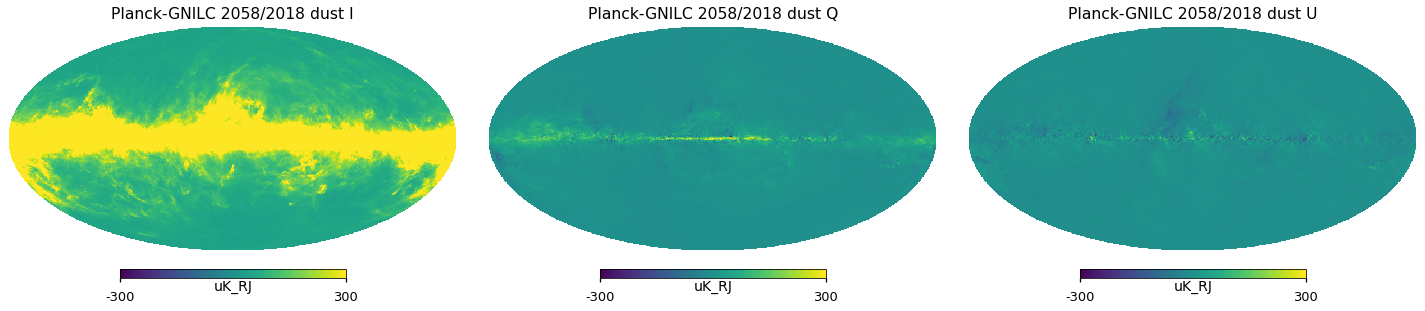

In [22]:
plt.figure(figsize=(20, 5))
for i_pol, pol in components:
    hp.mollview(
        m_planck_varres[i_pol],
        title="Planck-GNILC 2058/2018 dust " + pol,
        sub=131 + i_pol,
        unit=m_planck_varres.unit,
        min=-300,
        max=300,
    )

## Transform maps to Poltens quantities 

In [23]:
def map_to_log_pol_tens(m):
    P = np.sqrt(m[1] ** 2 + m[2] ** 2)
    log_pol_tens = np.empty_like(m)
    log_pol_tens[0] = np.log(m[0] ** 2 - P ** 2) / 2.0
    log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0
    return log_pol_tens


def log_pol_tens_to_map(log_pol_tens):
    P = np.sqrt(log_pol_tens[1] ** 2 + log_pol_tens[2] ** 2)
    m = np.empty_like(log_pol_tens)
    exp_i = np.exp(log_pol_tens[0])
    m[0] = exp_i * np.cosh(P)
    m[1:] = log_pol_tens[1:] / P * exp_i * np.sinh(P)
    return m


def sigmoid(x, x0, width, power=4):
    """Sigmoid function given start point and width
    Parameters
    ----------
    x : array
        input x axis
    x0 : float
        value of x where the sigmoid starts (not the center)
    width : float
        width of the transition region in unit of x
    power : float
        tweak the steepness of the curve
    Returns
    -------
    sigmoid : array
        sigmoid, same length of x"""
    return 1.0 / (1 + np.exp(-power * (x - x0 - width / 2) / width))

In [24]:
log_pol_tens_varres = map_to_log_pol_tens(m_planck_varres.value)

/tmp/ipykernel_7767/1566809701.py:4: RuntimeWarning: invalid value encountered in log
  log_pol_tens[0] = np.log(m[0] ** 2 - P ** 2) / 2.0
/tmp/ipykernel_7767/1566809701.py:5: RuntimeWarning: invalid value encountered in log
  log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0


Checking NaNs  on the Poltens map 

In [25]:
print(
    f"{np.isnan(log_pol_tens_varres[0]).sum()  } pixels out of { maskmono.size} are NaNs in Log Pol Tens maps "
)

5 pixels out of 50331648 are NaNs in Log Pol Tens maps 


In [26]:
for i in range(3):
    log_pol_tens_varres[i, np.isnan(log_pol_tens_varres[i])] = np.nanmedian(
        log_pol_tens_varres[i]
    )

Set all the NaNs to the map median value  


In [27]:
assert np.isnan(log_pol_tens_varres).sum() == 0

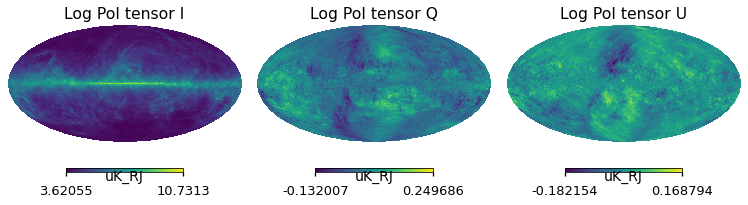

In [28]:
for i_pol, pol in components:
    hp.mollview(
        log_pol_tens_varres[i_pol],
        title="Log Pol tensor " + pol,
        sub=131 + i_pol,
        unit=m_planck_varres.unit,
    )

In [29]:
from scipy.optimize import curve_fit

In [30]:
def model(ell, A, gamma):
    out = A * ell ** gamma
    return out

In [31]:
def run_anafast(m, lmax):
    clanaf = hp.anafast(m, lmax=lmax)
    cl = {}
    cl["TT"] = clanaf[0]
    cl["EE"] = clanaf[1]
    cl["BB"] = clanaf[2]
    cl["TE"] = clanaf[3]
    ell = np.arange(lmax + 1)

    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl


def run_namaster(m, mask, lmax, nlbins):
    """Compute C_ell with NaMaster
    Parameters
    ----------
    m : numpy array
        T only or TQU HEALPix map
    mask : numpy array
        mask, 1D, 0 for masked pixels,
        needs to have same Nside of the input map
    lmax : int
        maximum ell of the spherical harmonics transform
    Returns
    -------
    ell : numpy array
        array of ell from 0 to lmax (length lmax+1)
    cl_norm : numpy array
        ell (ell+1)/2pi factor to turn C_ell into D_ell
        first element is set to 1
    cl : dict of numpy arrays
        dictionary of numpy arrays with all components
        of the spectra, for now only II, EE, BB, no
        cross-spectra
    """

    nside = hp.npix2nside(len(mask))
    # b = nmt.NmtBin.from_nside_linear(nside, 16)
    # leff = b.get_effective_ells()
    binning = nmt.NmtBin(nside=nside, nlb=nlbins, lmax=lmax, is_Dell=False)

    cl = {}

    if len(m) == 3:
        f_0 = nmt.NmtField(mask, [m[0]])
        f_2 = nmt.NmtField(
            mask, m[1:].copy(), purify_b=True
        )  # NaMaster masks the map in-place
        cl_namaster = nmt.compute_full_master(f_2, f_2, binning)
        cl["EE"] = np.concatenate([[0, 0], cl_namaster[0]])
        cl["BB"] = np.concatenate([[0, 0], cl_namaster[3]])
        cl_namaster = nmt.compute_full_master(f_0, f_2, binning)
        cl["TE"] = np.concatenate([[0, 0], cl_namaster[0]])
    elif m.ndim == 1:
        m = m.reshape((1, -1))
        f_0 = nmt.NmtField(mask, [m[0]])

    cl_namaster_I = nmt.compute_full_master(f_0, f_0, binning)

    cl["TT"] = np.concatenate([[0, 0], cl_namaster_I[0]])
    ell = np.concatenate([[0, 1], binning.get_effective_ells()])
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl

In [32]:
print("run anafast on full  sky  ")
ell, cl_norm, cl = run_anafast(log_pol_tens_varres, lmax)

run anafast on full  sky  


# (New) employing spectral indices from literature 

- https://arxiv.org/pdf/1801.04945.pdf and https://www.aanda.org/articles/aa/pdf/2016/09/aa28503-16.pdf
- 2 pivotal scales `ell1=110` and `ell2=800 ` 
- non zero TE  spectrum 



/tmp/ipykernel_7767/3409733669.py:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma
/tmp/ipykernel_7767/3409733669.py:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma
/tmp/ipykernel_7767/3409733669.py:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma
/tmp/ipykernel_7767/3409733669.py:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma


(1e-07, 0.1)

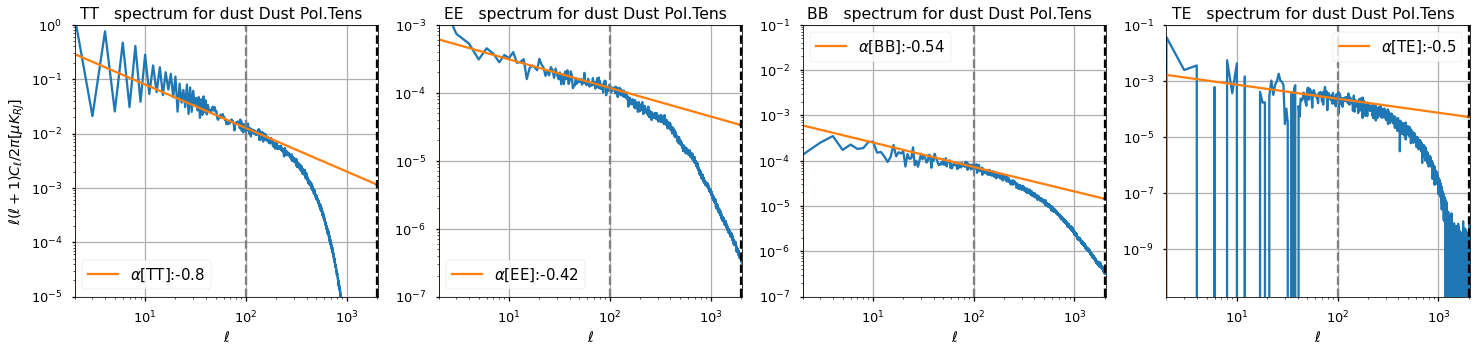

In [33]:
ell_fit_low = {"TT": 50, "EE": 50, "BB": 50, "TE": 50}
ell_fit_high = {"TT": 100, "EE": 100, "BB": 100, "TE": 100}
gamma_fit2 = {"TT": -0.8, "EE": -0.42, "BB": -0.54, "TE": -0.50}
A_fit, gamma_fit, A_fit_std, gamma_fit_std = {}, {}, {}, {}
plt.figure(figsize=(25, 5))
A_fit2 = {}
smallscales = []

ell_pivot = 2000
for ii, pol in enumerate(spectra_components):
    plt.subplot(141 + ii)
    xdata = np.arange(ell_fit_low[pol], ell_fit_high[pol])
    ydata = xdata * (xdata + 1) / np.pi / 2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)
    A_fit2[pol] = np.fabs(A_fit[pol]) * ell_fit_high[pol] ** (
        gamma_fit[pol] - gamma_fit2[pol]
    )
    plt.loglog(ell, ell * (ell + 1) / np.pi / 2 * cl[pol])
    scaling = model(ell[:ell_pivot], A_fit2[pol], gamma_fit2[pol])
    scaling[:2] = 0
    plt.plot(ell[:ell_pivot], scaling, label=r"$\alpha$" + f"[{pol}]:{gamma_fit2[pol]}")
    smallscales.append(scaling)

    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray")
    plt.axvline(ell_pivot, linestyle="--", color="k")
    plt.grid()
    plt.title(f"{pol}   spectrum for dust Dust Pol.Tens  ")

    plt.xlabel(("$\ell$"))
    plt.xlim(2, lmax)
    plt.legend(fontsize=15)

for ii, pol in enumerate(spectra_components):
    # we change the EE and BB power laws
    xdata = np.arange(ell_fit_high[pol], ell.size)
    ydata = xdata * (xdata + 1) / np.pi / 2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)

    plt.subplot(141 + ii)
    if pol == "TE":
        A_fit2[pol] = A_fit2[pol] * ell_pivot ** (gamma_fit2[pol] - gamma_fit2["TE"])
        scaling = model(ell[ell_pivot:], A_fit2[pol], gamma_fit2["TE"])

        plt.plot(
            ell[ell_pivot:],
            scaling,
            linewidth=3,
            alpha=0.4,
            color="k",
        )
        smallscales[ii] = np.concatenate([smallscales[ii], scaling])
    else:
        A_fit2[pol] = A_fit2[pol] * ell_pivot ** (gamma_fit2[pol] - gamma_fit2["TT"])
        scaling = model(ell[ell_pivot:], A_fit2[pol], gamma_fit2["TT"])

        plt.plot(
            ell[ell_pivot:],
            scaling,
            linewidth=3,
            alpha=0.4,
            color="k",
        )
        smallscales[ii] = np.concatenate([smallscales[ii], scaling])

plt.subplot(141)

plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
plt.ylim(1e-5, 1e0)
plt.subplot(142)
plt.ylim(1e-7, 1e-3)
plt.subplot(143)
plt.ylim(1e-7, 1e-3)
plt.subplot(143)
plt.ylim(1e-7, 1e-1)

In [34]:
cl_ss = [
    smallscales[ii] * sigmoid(ell, ell_fit_high[pol], ell_fit_high[pol] / 10) / cl_norm
    for ii, pol in enumerate(spectra_components)
]

# (NEW)  Modulating  intensity and polarization small scales 

- we will produce a modulation map at a very low reso (~ 11.3 degrees), to save memory we consider `nside=512`
- we downgrade the `iqu` map at `nside=512` for the same reason as above 
- we  considering the center of pixels  at `nside=8`  
- we  estimate the TT and EE power spectra in a circle of 11.3 deg apodized by 5 deg and  centered in each `nside=8`   pixel 
- the modulation value in the patch   $p$ is given by : 
$$
A _p = \sqrt{\frac{C_{\ell=80, p}} {C_{ell=80,full}}  }
$$
- notice that in a given pixel we actually take an average value as the circles of neighbouring pixels  overlap, for this reason we have to divide the modulation map by the map encoding the  effective number of estimates 
- we apply a smoothing w/ a gaussian beam at 11.5 deg, to avoid sharp transitions . 



In [35]:
nsidepatches = 8
centers = np.vstack(
    hp.pix2vec(ipix=np.arange(hp.nside2npix(nsidepatches)), nside=nsidepatches)
).T
mout = hp.ud_grade(log_pol_tens_varres, nside_out=512)

fit_model = lambda x, Ad, alpha: Ad * (x / 100) ** (alpha)

tmod = np.zeros(hp.nside2npix(hp.get_nside(mout)))
pmod = np.zeros(hp.nside2npix(hp.get_nside(mout)))
n_eff = np.zeros_like(mout[0])


def bin_cell(cell, dig):
    cb = []
    errb = []
    for i in np.unique(dig):
        msk = dig == i
        cb.append(cell[msk].mean())
        errb.append(cell[msk].std())

    return np.array(cb), np.array(errb)


def bin_ell(ells, dig):
    lb = []
    dl = []
    for i in np.unique(dig):
        msk = dig == i
        lb.append(ells[msk].mean())
        dl.append((ells[msk].max() - ells[msk].min()) / 2)
    return np.array(lb), np.array(dl)


for ipix, c in enumerate(centers):
    patch = np.zeros_like(mout[0])
    maskpixs = hp.query_disc(nside=hp.get_nside(mout), vec=c, radius=np.radians(11.3))
    patch[maskpixs] = 1

    apo_patch = nmt.mask_apodization(patch, 5, apotype="C2")
    fsky = apo_patch.sum() / apo_patch.size

    if ipix % 100 == 0:
        print(ipix)
    ellp, norm, clp = run_anafast(m=mout * apo_patch, lmax=512)
    # bin the anafast spectra
    digi = np.digitize(ellp, np.logspace(1, 2.5, 24))

    dtt, errtt = bin_cell((clp["TT"]) / fsky, digi)
    dee, erree = bin_cell((clp["EE"]) / fsky, digi)

    lb, delta_l = bin_ell(ellp, digi)
    # fit power law parameters for ell<100 for EE and 80<ell<200 for TT
    lmask = (lb) < 100
    lmaskt = np.logical_and((lb) < 200, lb > 80)
    param_ee, _ = curve_fit(
        fit_model, ydata=dee[lmask], xdata=lb[lmask], sigma=erree[lmask]
    )
    param_tt, _ = curve_fit(
        fit_model, ydata=dtt[lmaskt], xdata=lb[lmaskt], sigma=errtt[lmaskt]
    )
    # assign modulation in the circle patch
    l_ = 80

    pmod += np.sqrt(fit_model(l_, *param_ee) / cl["EE"][l_]) * apo_patch
    tmod += np.sqrt(fit_model(l_, *param_tt) / cl["TT"][l_]) * apo_patch
    n_eff += apo_patch

0
100
200
300
400
500
600
700


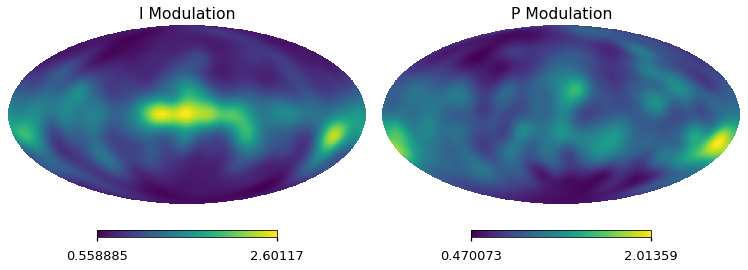

In [36]:
psm = hp.smoothing(pmod / n_eff, fwhm=np.radians(11.5))
tsm = hp.smoothing(tmod / n_eff, fwhm=np.radians(11.5))
hp.mollview(psm, sub=122, title="P Modulation")
hp.mollview(tsm, sub=121, title="I Modulation")

In [37]:
hp.write_map(
    datadir / "dust_gnilc_modulation_nside512.fits",
    [tsm, psm],
    column_units="",
    coord="G",
    column_names=["TEMPERATURE", "POLARISATION"],
    dtype=np.float32,
    overwrite=True,
)

## Small scale injection


In [38]:
output_nside = 2048
output_lmax = output_nside
lmax = output_lmax
ell = np.arange(output_lmax + 1)
cl_norm = ell * (ell + 1) / np.pi / 2
cl_norm[:1] = 1

In [39]:
np.random.seed(8192)

In [40]:
log_ss = hp.synfast(
    cl_ss,
    lmax=lmax,
    new=True,
    nside=output_nside,
)

In [41]:
polarization_mod = hp.ud_grade(psm, nside_out=output_nside)
temperature_mod = hp.ud_grade(tsm, nside_out=output_nside)

In [42]:
log_ss_modulated = log_ss.copy()
log_ss_modulated[0] = log_ss[0] * temperature_mod
log_ss_modulated[1:] = log_ss[1:] * polarization_mod

In [43]:

alm_log_pol_tens_fullsky = hp.map2alm(
    log_pol_tens_varres, lmax=output_lmax, use_pixel_weights=True
)

ii_LS_alm = np.empty_like(alm_log_pol_tens_fullsky)
for ii, pol in enumerate(spectra_components[:-1]):

    sig_func = sigmoid(ell, x0=ell_fit_high[pol], width=ell_fit_high[pol] / 10)

    ii_LS_alm[ii] = hp.almxfl(alm_log_pol_tens_fullsky[ii], (1.0 - sig_func) ** 0.2)


log_ls = hp.alm2map(ii_LS_alm, nside=output_nside)
ii_outmap = log_ls + log_ss_modulated  # * planck_mask  +   (1-  planck_mask)* log_ss

## small scales included only outside the `GAL097` planck mask 
Employ observed data inside the Gal. Plane 


In [44]:
galplane_mask = hp.read_map(planck_mask_filename, ["GAL097"])

In [45]:
output_map = log_pol_tens_to_map(ii_outmap)

output_map = galplane_mask * output_map + (1 - galplane_mask) * m_planck_varres.value

In [46]:
hp.write_map(
    datadir / "dust_gnilc_template_nside2048.fits",
    output_map,
    column_units="uK_RJ",
    coord="G",
    dtype=np.float32,
    overwrite=True,
)

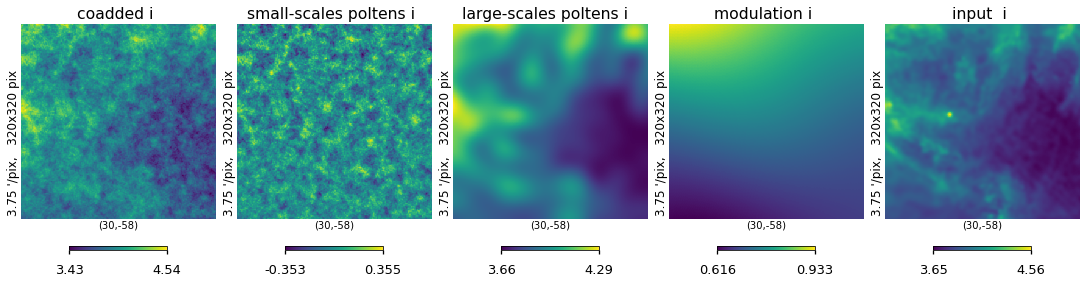

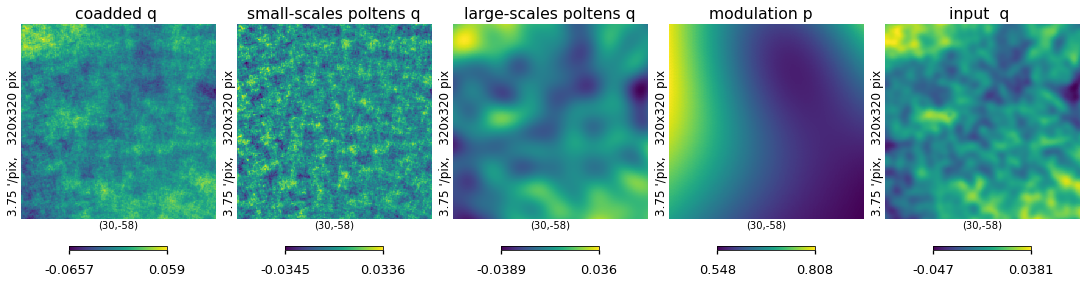

In [47]:
plt.figure(figsize=(15, 5))
hp.gnomview(
    log_ss_modulated[0],
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=152,
    title="small-scales poltens i ",
)
hp.gnomview(
    log_ls[0],
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=153,
    title="large-scales poltens i  ",
)
hp.gnomview(
    ii_outmap[0], reso=3.75, xsize=320, rot=[30, -58], sub=151, title="coadded i "
)
hp.gnomview(
    log_pol_tens_varres[0],
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=155,
    title="input  i ",
)
hp.gnomview(
    temperature_mod, reso=3.75, xsize=320, rot=[30, -58], sub=154, title="modulation i "
)

plt.figure(figsize=(15, 5))
hp.gnomview(
    log_ss_modulated[1],
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=152,
    title="small-scales poltens q",
)
hp.gnomview(
    log_ls[1],
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=153,
    title="large-scales poltens q",
)
hp.gnomview(
    ii_outmap[1], reso=3.75, xsize=320, rot=[30, -58], sub=151, title="coadded q "
)
hp.gnomview(
    log_pol_tens_varres[1],
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=155,
    title="input  q ",
)
hp.gnomview(
    polarization_mod,
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=154,
    title="modulation p  ",
)

In [48]:
del (
    log_ls,
    ii_LS_alm,
    log_ss,
    log_ss_modulated,
    alm_log_pol_tens_fullsky,
)
del temperature_mod, polarization_mod

### UDgrade to accelerate the Namaster computation 

In [49]:
output_map512 = hp.ud_grade(output_map, nside_out=512)
input_map512 = hp.ud_grade(m_planck_varres.value, nside_out=512)

In [50]:
bkmaskfile = datadir / "bk14_mask_gal_n0512.fits"
if not bkmaskfile.exists():
    !wget -O $bkmaskfile http://bicepkeck.org/BK14_datarelease/bk14_mask_gal_n0512.fits
maskbk = hp.read_map(bkmaskfile, verbose=False)
idx = np.where((maskbk < 0) | (~np.isfinite(maskbk)))
maskbk[idx] = 0

--2023-02-10 10:09:46--  http://bicepkeck.org/BK14_datarelease/bk14_mask_gal_n0512.fits
Resolving bicepkeck.org (bicepkeck.org)... 140.247.151.131
Connecting to bicepkeck.org (bicepkeck.org)|140.247.151.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12591360 (12M) [image/fits]
Saving to: ‘data/bk14_mask_gal_n0512.fits’

data/bk14_mask_gal_ 100%[===================>]  12.01M  3.26MB/s    in 4.4s    

2023-02-10 10:09:51 (2.72 MB/s) - ‘data/bk14_mask_gal_n0512.fits’ saved [12591360/12591360]



In [51]:
aoa = datadir / "weights_aoa_spsat_apo_gal_512.fits"

if not aoa.exists():
    !wget -O $aoa "https://portal.nersc.gov/project/cmb/pysm-data/dust_gnilc/inputs/weights_aoa_spsat_apo_gal_512.fits"

--2023-02-10 10:09:52--  https://portal.nersc.gov/project/cmb/pysm-data/dust_gnilc/inputs/weights_aoa_spsat_apo_gal_512.fits
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.112, 128.55.206.110, 128.55.206.106, ...
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12591360 (12M)
Saving to: ‘data/weights_aoa_spsat_apo_gal_512.fits’

data/weights_aoa_sp 100%[===================>]  12.01M  --.-KB/s    in 0.1s    

2023-02-10 10:09:53 (83.6 MB/s) - ‘data/weights_aoa_spsat_apo_gal_512.fits’ saved [12591360/12591360]



In [52]:
mask_aoa = hp.read_map(aoa, verbose=False)

In [53]:
planck_masks = {
    "GAL099": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL099"]), nside_out=512),
    "GAL097": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL097"]), nside_out=512),
    "GAL090": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL090"]), nside_out=512),
    "GAL080": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL080"]), nside_out=512),
    "GAL070": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL070"]), nside_out=512),
    "GAL060": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL060"]), nside_out=512),
    "GAL040": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL040"]), nside_out=512),
    "GAL020": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL020"]), nside_out=512),
}

In [54]:
planck_masks_2048 = {
    "GAL099": hp.read_map(planck_mask_filename, ["GAL099"]),
    "GAL097": hp.read_map(planck_mask_filename, ["GAL097"]),
    "GAL090": hp.read_map(planck_mask_filename, ["GAL090"]),
    "GAL080": hp.read_map(planck_mask_filename, ["GAL080"]),
    "GAL070": hp.read_map(planck_mask_filename, ["GAL070"]),
    "GAL060": hp.read_map(planck_mask_filename, ["GAL060"]),
    "GAL040": hp.read_map(planck_mask_filename, ["GAL040"]),
    "GAL020": hp.read_map(planck_mask_filename, ["GAL020"]),
}

In [55]:
ell, cl_norm, clo = run_anafast(output_map512, lmax=2048)
ell, cl_norm, cli = run_anafast(input_map512, lmax=2048)

In [56]:
colors = plt.cm.cividis(np.linspace(0, 1, len(planck_masks.keys()) + 1))

GAL099
GAL097
GAL090
GAL080
GAL070
GAL060
GAL040
GAL020


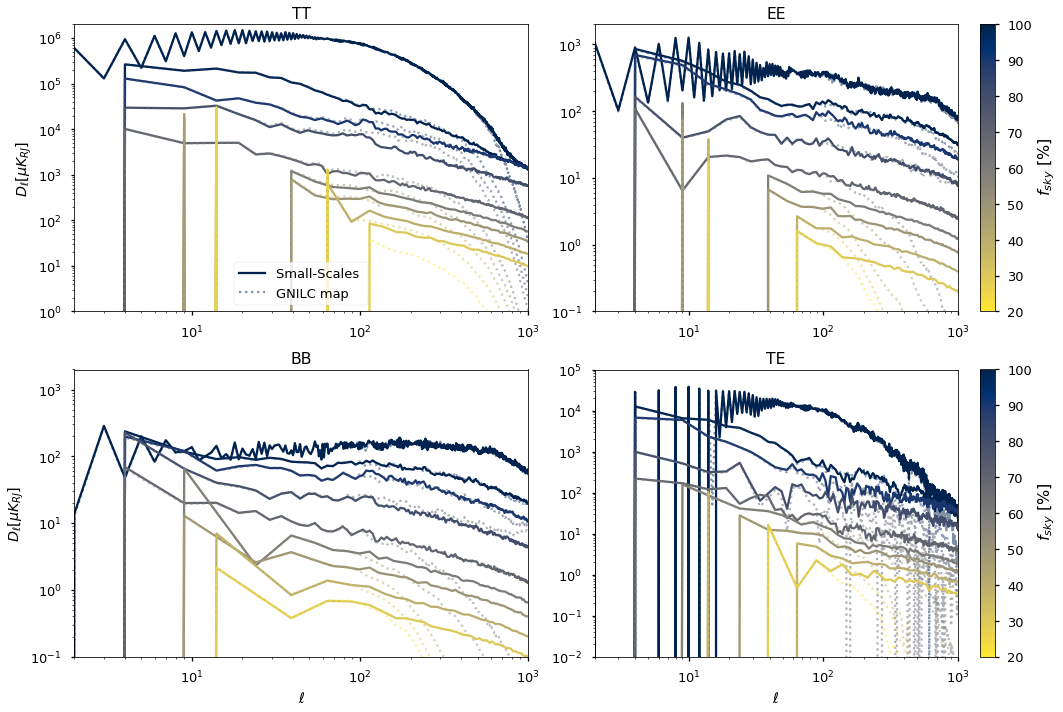

In [57]:
bins = {
    "GAL099": 5,
    "GAL097": 5,
    "GAL090": 5,
    "GAL080": 5,
    "GAL070": 15,
    "GAL060": 15,
    "GAL040": 25,
    "GAL020": 25,
}
plt.figure(figsize=(15, 10))
import os

# for jj, k in enumerate([ "GAL080","GAL070","GAL040","GAL020"  ])  :
for jj, k in enumerate(planck_masks.keys()):
    # fspectra = datadir / f"dust_gnilc_varres_no_monopole_gal{k[3:]}_spectra.npz"
    fspectra = (
        datadir / f"dust_gnilc_{gnilc_template}_no_monopole_gal{k[3:]}_spectra.npz"
    )
    print(k)
    if os.path.exists(fspectra):
        input_ell = np.load(fspectra)["ell"]
        cl_in = {kk: np.load(fspectra)[kk] for kk in spectra_components + ["TE"]}
    else:
        input_ell, cl_norm, cl_in = run_namaster(
            m=input_map512, mask=planck_masks[k], lmax=1300, nlbins=bins[k]
        )
        np.savez(
            fspectra,
            ell=input_ell,
            TT=cl_in["TT"],
            EE=cl_in["EE"],
            BB=cl_in["BB"],
            TE=cl_in["TE"],
        )

    fspectra = (
        datadir
        / f"dust_gnilc_{gnilc_template}_pysm_circles_planck_gal{k[3:]}_spectra.npz"
    )
    if os.path.exists(fspectra):
        output_ell = np.load(fspectra)["ell"]
        cl_out = {kk: np.load(fspectra)[kk] for kk in spectra_components + ["TE"]}
    else:

        # output_ell, cl_norm, cl_out = run_namaster(m = output_map, mask =planck_masks[k] ,lmax=3000 , nlbins = bins[k]  )
        output_ell, cl_norm, cl_out = run_namaster(
            m=output_map512, mask=planck_masks[k], lmax=1300, nlbins=bins[k]
        )
        np.savez(
            fspectra,
            ell=output_ell,
            TT=cl_out["TT"],
            EE=cl_out["EE"],
            BB=cl_out["BB"],
            TE=cl_out["TE"],
        )

    for ii, pol in enumerate(["TT", "EE", "BB", "TE"]):
        plt.subplot(2, 2, ii + 1)
        if jj == 0:
            plt.title(pol)
            plt.loglog(
                ell,
                ell ** 2 * (clo[pol]),
                label="Small-Scales ",
                color=colors[0],
            )
            plt.loglog(
                ell,
                ell ** 2 * (cli[pol]),
                ":",
                label="GNILC map ",
                color=colors[0],
                alpha=0.5,
            )
        plt.loglog(output_ell, output_ell ** 2 * (cl_out[pol]), color=colors[jj])
        # ,label =f"{k}")
        plt.loglog(
            input_ell,
            input_ell ** 2 * (cl_in[pol]),
            ":",
            color=colors[jj + 1],
            alpha=0.5,
        )

plt.subplot(221)
plt.legend()
plt.ylabel("$ D_\ell  [\mu K_{RJ}]$")
plt.ylim(1e0, 2e6)
plt.xlim(2, 1e3)

plt.subplot(222)
plt.ylim(1e-1, 2e3)
plt.xlim(2, 1e3)
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.cividis_r, norm=plt.Normalize(vmin=20.0, vmax=100)
)
cb = plt.colorbar(sm)
cb.set_label(r" $f_{sky}$ [%]", rotation="90", fontsize=16)
plt.subplot(223)
plt.ylabel("$ D_\ell  [\mu K_{RJ}]$")
plt.xlabel(("$\ell$"))

plt.ylim(1e-1, 2e3)
plt.xlim(2, 1e3)

plt.subplot(224)
plt.ylim(1e-2, 1e5)
plt.xlim(2, 1e3)

plt.xlabel(("$\ell$"))
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.cividis_r, norm=plt.Normalize(vmin=20.0, vmax=100)
)
cb = plt.colorbar(sm)
cb.set_label(r" $f_{sky}$ [%]", rotation="90", fontsize=16)
plt.tight_layout()

/tmp/ipykernel_7767/3560805298.py:27: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(ell, (clo["EE"] / clo["BB"]), color=colors[0], alpha=1)
/tmp/ipykernel_7767/3560805298.py:28: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(output_ell, (cl_out["EE"] / cl_out["BB"]), color=colors[jj + 1], alpha=1)
/tmp/ipykernel_7767/3560805298.py:28: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(output_ell, (cl_out["EE"] / cl_out["BB"]), color=colors[jj + 1], alpha=1)
/tmp/ipykernel_7767/3560805298.py:28: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(output_ell, (cl_out["EE"] / cl_out["BB"]), color=colors[jj + 1], alpha=1)
/tmp/ipykernel_7767/3560805298.py:28: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(output_ell, (cl_out["EE"] / cl_out["BB"]), color=colors[jj + 1], alpha=1)
/tmp/ipykernel_7767/3560805298.py:28: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(output_ell, 

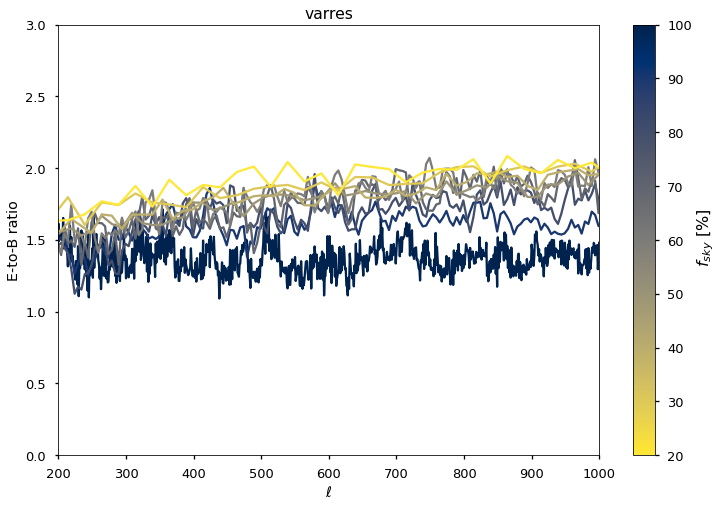

In [58]:
# plt.figure(figsize=(15,10 ))
import os

for jj, k in enumerate(planck_masks.keys()):

    fspectra = datadir / f"dust_gnilc_varres_pysm_circles_planck_gal{k[3:]}_spectra.npz"
    if os.path.exists(fspectra):
        #        print("read Namaster spectra  ")
        output_ell = np.load(fspectra)["ell"]
        cl_out = {kk: np.load(fspectra)[kk] for kk in spectra_components + ["TE"]}
    else:
        #        print("computing spectra")

        output_ell, cl_norm, cl_out = run_namaster(
            m=output_map512, mask=planck_masks[k], lmax=1300, nlbins=bins[k]
        )
        np.savez(
            fspectra,
            ell=output_ell,
            TT=cl_out["TT"],
            EE=cl_out["EE"],
            BB=cl_out["BB"],
            TE=cl_out["TE"],
        )

    if jj == 0:
        plt.plot(ell, (clo["EE"] / clo["BB"]), color=colors[0], alpha=1)
    plt.plot(output_ell, (cl_out["EE"] / cl_out["BB"]), color=colors[jj + 1], alpha=1)

plt.xlim(200, 1e3)
plt.ylim(0, 3)
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.cividis_r, norm=plt.Normalize(vmin=20.0, vmax=100)
)
cb = plt.colorbar(sm)
cb.set_label(r" $f_{sky}$ [%]", rotation="90", fontsize=16)
plt.xlabel(("$\ell$"))
plt.ylabel(("E-to-B ratio"))

plt.title(gnilc_template)
plt.tight_layout()

#  we further validate E and B spectra  also within the BK and Southern Hole patches

In [59]:
def ClBB(mask, mapp):
    map1 = mapp.copy()
    b = nmt.NmtBin.from_nside_linear(hp.get_nside(mask), 35)
    f_2 = nmt.NmtField(mask, map1, purify_b=True)
    cl_22 = nmt.compute_full_master(f_2, f_2, b)
    ell_arr = b.get_effective_ells()
    return (ell_arr, cl_22[3], cl_22[0])

In [60]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc

In [61]:
i_dic = {}
(ells, clBB_i, clEE_i) = ClBB(mask_aoa, input_map512[1:, :])

i_dic["S4"] = [clBB_i, clEE_i]
(ells, clBB_i, clEE_i) = ClBB(maskbk, input_map512[1:, :])
i_dic["BK"] = [clBB_i, clEE_i]

In [62]:
o_dic = {}

(oells, clBB_o, clEE_o) = ClBB(mask_aoa, output_map512[1:, :])
o_dic["S4"] = [clBB_o, clEE_o]
(oells, clBB_o, clEE_o) = ClBB(maskbk, output_map512[1:, :])
o_dic["BK"] = [clBB_o, clEE_o]

In [63]:
bk = (np.sqrt(4.4) * u.uK_CMB).to(
    "uK_RJ", equivalencies=u.cmb_equivalencies(353 * u.GHz)
)

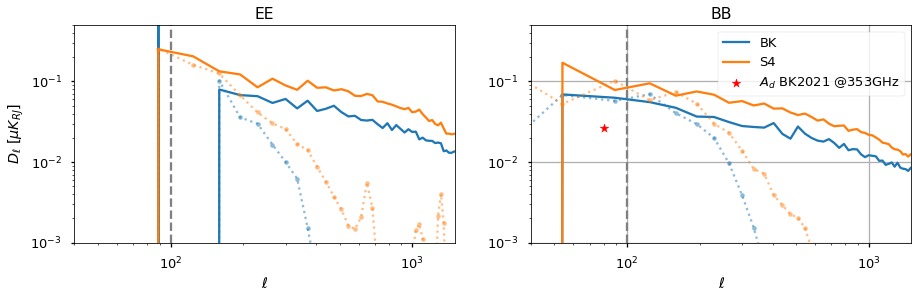

In [64]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.title("EE")
plt.ylabel("$ D_\ell\,\,  [\mu K_{RJ}]$")
plt.xlabel(("$\ell$"))

plt.plot(
    ells,
    ells * (ells + 1.0) * i_dic["BK"][1] / (2.0 * np.pi),
    ".",
    alpha=0.5,
    color="C0",
    linestyle=":",
)
plt.plot(
    oells,
    oells * (oells + 1.0) * o_dic["BK"][1] / (2.0 * np.pi),
    label="BK",
    color="C0",
)
plt.plot(
    ells,
    ells * (ells + 1.0) * i_dic["S4"][1] / (2.0 * np.pi),
    ".",
    alpha=0.5,
    color="C1",
    linestyle=":",
)
plt.plot(
    oells,
    oells * (oells + 1.0) * o_dic["S4"][1] / (2.0 * np.pi),
    label="Southern-Hole",
    color="C1",
)
plt.loglog()
plt.ylim(1e-3, 5e-1)
plt.xlim(40, 1.5e3)
plt.axvline(ell_fit_high[pol], linestyle="--", color="gray")
plt.axvline(ell_pivot, linestyle="--", color="k")
plt.subplot(122)
plt.title("BB")
plt.xlabel(("$\ell$"))
plt.plot(
    ells,
    ells * (ells + 1.0) * i_dic["BK"][0] / (2.0 * np.pi),
    ".",
    alpha=0.5,
    color="C0",
    linestyle=":",
)
plt.plot(
    oells,
    oells * (oells + 1.0) * o_dic["BK"][0] / (2.0 * np.pi),
    label="BK",
    color="C0",
)
plt.plot(
    ells,
    ells * (ells + 1.0) * i_dic["S4"][0] / (2.0 * np.pi),
    ".",
    alpha=0.5,
    color="C1",
    linestyle=":",
)
plt.plot(
    oells,
    oells * (oells + 1.0) * o_dic["S4"][0] / (2.0 * np.pi),
    label="S4",
    color="C1",
)
plt.scatter(
    [80.0], [(bk ** 2).value], color="r", marker="*", label=r"$A_d$ BK2021 @353GHz"
)
plt.loglog()
plt.ylim(1e-3, 5e-1)
plt.xlim(40, 1.5e3)
plt.axvline(ell_fit_high[pol], linestyle="--", color="gray")
plt.axvline(ell_pivot, linestyle="--", color="k")
plt.legend()
plt.grid()

## Check polarization 

In [65]:
get_polfrac = lambda x: np.sqrt(x[1] ** 2 + x[2] ** 2) / x[0]

In [66]:
Pout = get_polfrac(output_map)
Pin = get_polfrac(m_planck_varres.value)
logpin = np.log10(Pin)
logpout = np.log10(Pout)

In [67]:
planck_masks_bool = {
    k: np.ma.masked_greater(m, 0).mask for k, m in planck_masks_2048.items()
}

In [68]:
mask_aoa2048 = hp.ud_grade(mask_aoa, nside_out=2048)
mask_bk2048 = hp.ud_grade(maskbk, nside_out=2048)

GAL099
GAL097
GAL090
GAL080
GAL070
GAL060
GAL040
GAL020


(-3.0, -0.5)

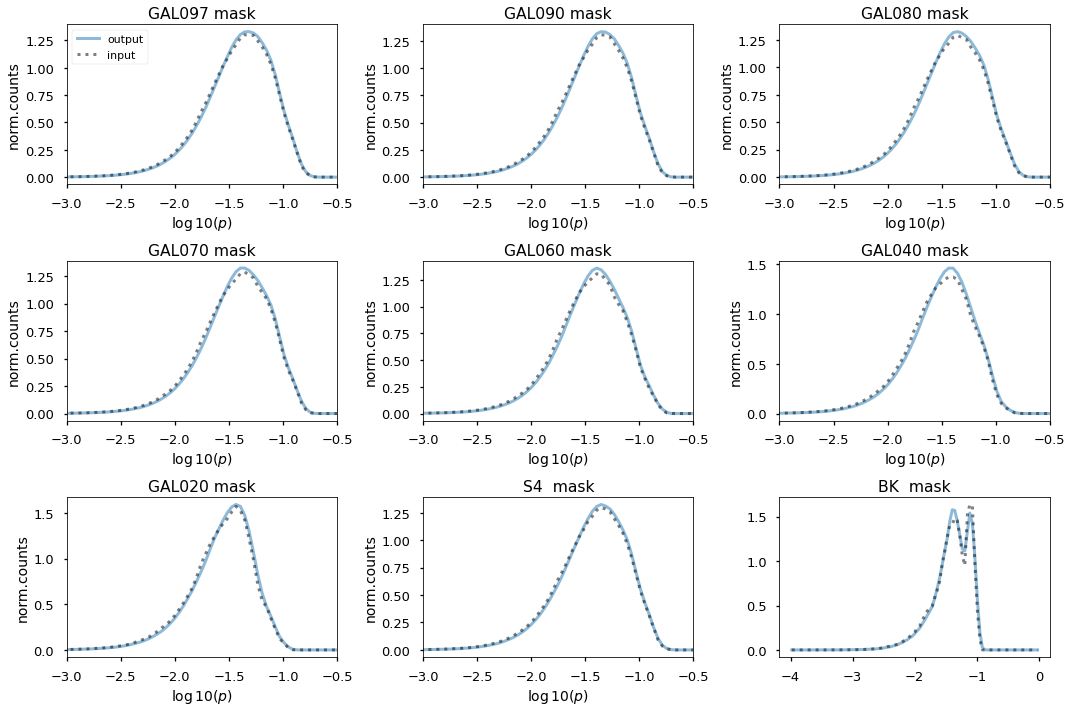

In [69]:
plt.figure(figsize=(15, 10))

for jj, pm in enumerate(planck_masks_bool.items()):
    k = pm[0]
    msk = pm[1]
    print(k)
    if k == "GAL099":
        continue
    plt.subplot(3, 3, jj)

    h, edg = np.histogram(logpout[msk], bins=np.linspace(-4, 0, 100), density=True)
    xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])

    plt.plot(xb, h, lw=3, color="C0", alpha=0.5, label="output")
    h, edg = np.histogram(logpin[msk], density=True, bins=np.linspace(-4, 0, 100))
    xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])

    plt.plot(xb, h, lw=3, alpha=0.5, color="k", linestyle=":", label="input")
    plt.ylabel("norm.counts", fontsize=14)
    plt.xlabel(r"$\log10( p )$", fontsize=14)
    plt.title(k + " mask")
    plt.xlim(-3, -0.5)

plt.tight_layout()
plt.subplot(331)
plt.legend(fontsize=11, loc="upper left")

plt.subplot(339)

h, edg = np.histogram(
    logpout[np.ma.masked_greater(mask_bk2048, 0).mask],
    bins=np.linspace(-4, 0, 100),
    density=True,
)
xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])
plt.plot(xb, h, lw=3, color="C0", alpha=0.5, label="output")
h, edg = np.histogram(
    logpin[np.ma.masked_greater(mask_bk2048, 0).mask],
    density=True,
    bins=np.linspace(-4, 0, 100),
)
xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])
plt.plot(xb, h, lw=3, alpha=0.5, color="k", linestyle=":", label="input")
plt.title("BK  mask")

plt.subplot(338)


h, edg = np.histogram(
    logpout[np.ma.masked_greater(mask_aoa2048, 0).mask],
    bins=np.linspace(-4, 0, 100),
    density=True,
)
xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])
plt.plot(xb, h, lw=3, color="C0", alpha=0.5, label="output")
h, edg = np.histogram(
    logpin[np.ma.masked_greater(mask_aoa2048, 0).mask],
    density=True,
    bins=np.linspace(-4, 0, 100),
)
xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])
plt.plot(xb, h, lw=3, alpha=0.5, color="k", linestyle=":", label="input")
plt.ylabel("norm.counts", fontsize=14)
plt.xlabel(r"$\log10( p )$", fontsize=14)
plt.title("S4  mask")
plt.xlim(-3, -0.5)